In [21]:
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, Layout
import ipywidgets as widgets
from scipy.stats import norm
import seaborn as sn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from IPython.display import display, Math

In [2]:
font_size = 16

In [3]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

<br>
<br>
<br>
<br>

# Bayesian Optimisation: Mastering Sequential Decision Making

<br>
<br>
<br>
<br>
PhD. Juan Ungredda

# Content

* Motivation of Bayesian Optimisation.
* Applications
* Bayesian Optimization Preview
* Gaussian process regression.
* Exploration vs Exploitation.
* Acquisition functions.
* Limitations.
* Advanced topics.

# Motivation of Bayesian Optimization.

Consider a function $f : \mathcal{X} \rightarrow \mathbb{R}$ in a bounded domain  $\mathcal{X} \subseteq \mathbb{R}^D $. We aim to,

<br>
$$
x^* = \text{argmax}_{x \in \mathcal{X}} f(x)
$$

<br>

* **Black-box Function**: Lacks a known analytical form. Only input-output pairs $ (x, f(x)) $ are observable.

<br>

* **Expensive**: There's a constraint on the number of function evaluations allowed.

<br>

* **Noisy or Uncertain Observations**: Function evaluations might have noise.

In [4]:
from scipy.optimize import minimize

TIME_PER_EVALUATION = 15


def expensive_function(x):
    x = x - 0.55
    return np.sin(x) + np.sin((2.0 ) * x) 

def random_optimizer(n, ub, lb):
    return np.random.random(n)* (ub - lb) + lb

def grid_search(n, ub,lb):
    return np.linspace(lb, ub,n)

def gradient_method(n, ub,lb):
    x0 = np.array([4.0])
    points = []
    def expensive_function_with_points(x):
        if len(points) < n:
            points.append(x)  # Store evaluated points
        return -expensive_function(x)
    # Minimize the function while storing evaluated points
    result = minimize(expensive_function_with_points, x0, method='Nelder-Mead', options={"maxiter":n})
    return np.array(points)
    
def optimization_factory(method):
    if method == "grid":
        return grid_search
    elif method == "random":
        return random_optimizer
    elif method == "gradient":
        return gradient_method

    
def format_time(minutes):
    if minutes < 60:
        return f"{minutes} minutes"
    elif minutes == 60:
        return "1 hour"
    else:
        hours = minutes // 60
        remaining_minutes = minutes % 60
        if remaining_minutes == 0:
            return f"{hours} hours"
        else:
            return f"{hours} hours and {remaining_minutes} minutes"

class optimizer_logic():
    def __init__(self, function, method, n):
        self.function = function
        self.method = method
        self.n = n
        
    def optimization_main(self):
        np.random.seed(1)
        lb = -2.7
        ub = 7.5

        x = optimization_factory(self.method)(self.n,lb, ub)
        y = self.function(x)

        x_best = x[np.argmax(y)]
        y_best = np.max(y)
        x_plot = np.linspace(lb, ub,100)
        y_plot = self.function(x_plot)

        sn.set_style("darkgrid")
        plt.plot(x_plot, y_plot, color="black", alpha=0.5,linestyle="--")
        plt.scatter(x, y, color="black",facecolors='white', edgecolors='black',s=40)
        plt.scatter(x_best, y_best, color="green")
        plt.xlim(lb, ub)
        plt.xlabel("$X$")
        plt.ylabel("$f$")
        plt.title(r'Method: {} , Number of Sampler: {} , Computational Time: {}'.format(self.method, len(x), format_time(TIME_PER_EVALUATION*len(x))))
    
    def update_method(self, method):
        self.method = method
        
    def update_n(self, n):
        self.n = n

In [5]:
output = widgets.Output()
options = ["random", "grid", "gradient"]
default =  options[0]
optimizer = optimizer_logic(expensive_function, default, n = 10)

def optimiser_changed(method):
    with output:
        if method['type'] == 'change' and method['name'] == 'value':
            output.clear_output(wait=True)
            plt.figure(figsize=(10, 6))
            optimizer.update_method(method["new"])
            optimizer.optimization_main()
            plt.show()

def number_of_samples_changed(number_of_samples):
    with output:
        output.clear_output(wait=True)    
        plt.figure(figsize=(10, 6))
        optimizer.update_n(number_of_samples)
        optimizer.optimization_main()
        plt.show()
            

dropdown = widgets.Dropdown(options=options, description=r'optimiser', value=default, layout=Layout(width='60%'))
dropdown.observe(optimiser_changed)
intBox = widgets.IntText(value=7,description='$n$:')
intBox.observe(lambda event: number_of_samples_changed(event['new']), names='value')

display(widgets.VBox([widgets.HBox([dropdown, intBox]), output]))
optimiser_changed({'type' : 'change', 'name' : 'value', 'new' : default});
hide_toggle(for_next=False)

# Applications

- **Model configuration in machine learning**: find optimal
hyper-parameter values, learning rates, number of layers, etc.

<center>
<img src="https://miro.medium.com/v2/resize:fit:1199/1*N8UXaiUKWurFLdmEhEHiWg.jpeg" alt="Neural Network" width="700">
<center>
    


# Applications

- **Adaptive experimentation**: Optimize a function embodied in a physical process.

<center>
<img src="https://mediapool.bmwgroup.com/cache/P9/201703/P90252892/P90252892-30-03-2017-bmw-motorsport-computational-fluid-dynamics-cfd-simulation-bmw-m4-dtm-2357px.jpg" alt="fluid dynamics" width="500">
<center>
    

# Applications

Many other problems:

- Robotics.
- Control, reinforcement learning.
- A/B testing.
- Scheduling, planning.
- Industrial design.
- Simulation-optimization.
- etc

# Bayesian Optimization Preview

In [6]:
class GaussianProcessRegressor:
    def __init__(self, kernel, sigma_noise=1e-6):
        self.kernel = kernel
        self.sigma_noise = sigma_noise

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.K = self.kernel(self.X_train, self.X_train)
        self.K += np.eye(len(self.X_train)) * self.sigma_noise  # Adding noise to the diagonal for numerical stability
        self.K_inv = np.linalg.inv(self.K)

    def predict(self, X_test):
        K_s = self.kernel(self.X_train, X_test)
        mu_s = K_s.T.dot(self.K_inv).dot(self.y_train)
        cov_s = self.kernel(X_test, X_test) - K_s.T.dot(self.K_inv).dot(K_s)
        return mu_s.reshape(-1), np.sqrt(np.diag(cov_s))

class kernel_gaussian():
    def __init__(self,length_scale=1.0, amplitude=1.0):
        self.length_scale = length_scale
        self.amplitude = amplitude
    
    def print_formula(self):
        eqn = r"""
k_{\text{RBF}}(x, x') = \exp\left(-\frac{(x - x')^2}{2l^2}\right)
"""
        display(Math(r"\text{RBF Kernel:}"))
        display(Math(eqn))
        
    def compute(self, x1, x2):
         return self.amplitude * np.exp(-0.5 * ((x1[:, None] - x2[None, :]) / self.length_scale)**2)


class expected_improvement():
    def __init__(self,model, best_observed_value, xi=1e-6):
        self.model = model
        self.best_observed_value = best_observed_value
        self.xi = xi
    
    def evaluate(self,x):
        mu, sigma = self.model.predict(x)
        with np.errstate(divide='warn'):
            z = (mu - self.best_observed_value - self.xi) / sigma
            ei = (mu - self.best_observed_value - self.xi) * norm.cdf(z) + sigma * norm.pdf(z)

        ei[sigma == 0.0] = 0.0  # Avoid division by zero
        return -ei

class posterior_mean():
    def __init__(self, model):
        self.model = model
        
    def evaluate(self, x):
        mu, _ = self.model.predict(x)
        return - mu
    
class posterior_std():
    def __init__(self, model):
        self.model = model
        
    def evaluate(self, x):
        _, std = self.model.predict(x)
        return - std
    
def acquisition_function_factory(method, model, max_val):
    if method == "ei":
        return expected_improvement(model, max_val)
    elif method == "exploit":
        return posterior_mean(model)
    elif method == "explore":
        return posterior_std(model)
    
class bayesian_optimization_logic():
    def __init__(self, method, function, n):
        self.function = function
        self.n = n
        self.method = method
        self.saved_solutions = {}
    
    def generate_random_data(self,n, ub, lb):
        return (np.random.random(n)*(ub - lb) + lb)
    
    def optimization_main(self):
        np.random.seed(5)
        lb = -2.7
        ub = 7.5
        rbf_kernel = kernel_gaussian(length_scale=0.5, amplitude=0.1)
        data_x = self.generate_random_data(3, ub, lb)
        data_y = self.function(data_x)
        
        x_plot = np.linspace(lb, ub, 100)
        y_plot = self.function(x_plot)

        sn.set_style("darkgrid")
        fig, axes = plt.subplots(2, 1, figsize=(10, 5), gridspec_kw={'height_ratios': [4, 1]})
        plt.subplot(2, 1, 1)
        plt.plot(x_plot, y_plot, color="black", alpha=0.5,linestyle="--")
        plt.scatter(data_x[:3], data_y[:3], color="black",facecolors='white', edgecolors='black',s=40)
        
        for iteration in range(self.n):
            if iteration in self.saved_solutions:
                x = self.saved_solutions[iteration]
            else:
                gp = GaussianProcessRegressor(kernel=rbf_kernel.compute, sigma_noise=1e-06)
                gp.fit(data_x, data_y)
                ei = acquisition_function_factory(self.method,gp, np.max(data_y))
                best_ei_val = np.inf
                recommended_x = np.inf
                candidate_points = np.linspace(lb, ub, 100)
                ei_vals = ei.evaluate(candidate_points)
                x = np.array([candidate_points[np.argmin(ei_vals)]])  
            y = self.function(x)
            plt.scatter(x, y, color="black",facecolors='white', edgecolors='black',s=40)
            data_x = np.concatenate([data_x, x])
            data_y = np.concatenate([data_y, y])
            
            plt.scatter(data_x, data_y, color="black",facecolors='white', edgecolors='black',s=40)
            
        gp_plot = GaussianProcessRegressor(kernel=rbf_kernel.compute, sigma_noise=1e-06)
        gp_plot.fit(data_x, data_y)
        mu , sigma = gp_plot.predict(x_plot)
        plt.plot(x_plot, mu, linestyle="--")
        plt.fill_between(x_plot, mu-1.96*sigma, mu+1.96*sigma, alpha=0.3)
        x_best = data_x[np.argmax(data_y)]
        y_best = np.max(data_y)
        plt.scatter(x_best, y_best, color="green",s=40)
        plt.xlim(lb, ub)
        plt.xlabel("$X$")
        plt.ylabel("$f$")
        plt.title(r'Total Number of Samples: {} , Computational Time: {}'.format(len(data_x), format_time(TIME_PER_EVALUATION*len(data_x))))
        
        plt.subplot(2, 1, 2)
        ei = acquisition_function_factory(self.method , gp_plot, np.max(data_y))
        ei_vals = -ei.evaluate(x_plot)
        
        plt.plot(x_plot, ei_vals)
        plt.scatter(x_plot[np.argmax(ei_vals)], np.max(ei_vals), color="red")
        plt.xlim(lb, ub)
        plt.xlabel("$X$")
        plt.ylabel(r"$\alpha(x)$")
        
    def update_n(self, n):
        self.n = n
        
    def update_method(self, method):
        self.method = method

In [7]:
output_2 = widgets.Output()
budget = 0
bo_optimizer = bayesian_optimization_logic("ei",expensive_function, n = budget)

def number_of_samples_changed_bo(number_of_samples):
    with output_2:
        output_2.clear_output(wait=True)    
        bo_optimizer.update_n(number_of_samples)
        bo_optimizer.optimization_main()
        plt.show()
            

intBoxBO = widgets.IntText(value=budget,description='BO samples:')
intBoxBO.observe(lambda event: number_of_samples_changed_bo(event['new']), names='value')

display(widgets.VBox([intBoxBO, output_2]))
number_of_samples_changed_bo(0)

hide_toggle()

# Gaussian Process Regression

A Gaussian process (GP) is defined by its mean function $m(x)$ and covariance function $k(x, x')$ as,

$$
f(x) \sim GP(m(x), k(x, x'))
$$


<br>

- Model is fully determined by $m(x)$ and $k(x, x')$
- Posterior can be computed in closed form.
- Provides mean predictions and uncertainty calibration.

# Exploration vs Exploitation

<center>
<img src="https://www.vmcdn.ca/f/files/baytoday/images/business/20190306-gap-northgate.JPG;w=1200;h=800;mode=crop" alt="Shop" width="800">
<center>


In [8]:
output_3 = widgets.Output()
budget = 0
bo_optimizer_exploration_exploitation = bayesian_optimization_logic("exploit" , expensive_function, n = budget)

def number_of_samples_changed_bo_explore_exploit(number_of_samples):
    with output_3:
        output_3.clear_output(wait=True)    
        bo_optimizer_exploration_exploitation.update_n(number_of_samples)
        bo_optimizer_exploration_exploitation.optimization_main()
        plt.show()
            
def acquisition_function_changed(operation):
    with output_3:
        output_3.clear_output(wait=True)
        bo_optimizer_exploration_exploitation.update_method(operation)
        bo_optimizer_exploration_exploitation.optimization_main()
        plt.show()
        
intBoxBO = widgets.IntText(value=budget,description='BO samples:')
intBoxBO.observe(lambda event: number_of_samples_changed_bo_explore_exploit(event['new']), names='value')

options = ["exploit", "explore"]
acq_func_widget = widgets.Dropdown(options=options, description=r'Strategy', value=options[0], layout=Layout(width='30%'))
acq_func_widget.observe(lambda event: acquisition_function_changed(event['new']), names='value')

widget_acq_funcs = widgets.HBox([acq_func_widget, intBoxBO])
display(widgets.VBox([widget_acq_funcs, output_3]))
number_of_samples_changed_bo_explore_exploit(0)

hide_toggle()

# Bandit Problem

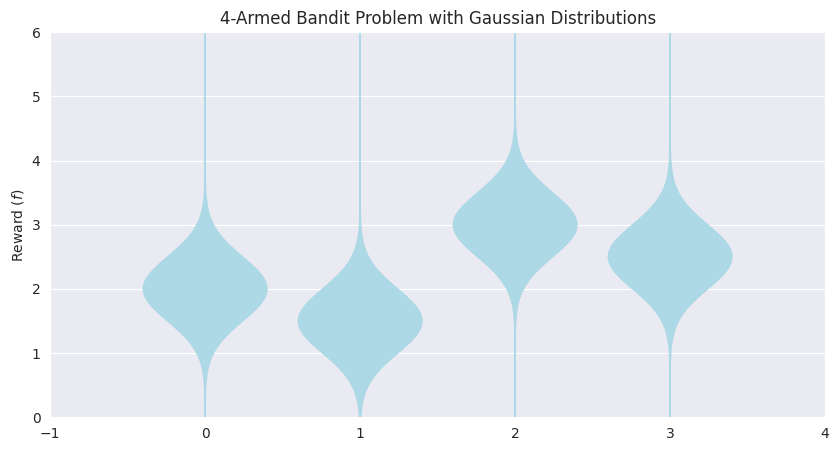

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

class Bandit:
    def __init__(self, mu, sigma, identifier):
        self.mu = mu
        self.sigma = sigma
        self.identifier = identifier

    def pull(self):
        return np.random.normal(self.mu, self.sigma)

def customized_violin(bandit, color, label, axis):
    x = np.linspace(-5, 8, 1000)
    data = norm.pdf(x, bandit.mu, bandit.sigma) * 0.5
    axis.fill_betweenx(x, -data + bandit.identifier,  data + bandit.identifier, color=color, alpha=1)
    
def plot_bandits(data, bandits, title):
    x = np.linspace(-3, 3, 1000)

    fig, ax = plt.subplots(figsize=(10, 5))
    plt.title(title)
    for i, bandit in enumerate(bandits):
        customized_violin(bandit, "lightblue", label = "Bandit {}".format(bandit.identifier), axis=ax)
    sn.swarmplot(data = data, x="bandit", y ="reward", order= range(len(bandits)) ,ax=ax)
    plt.ylabel('Reward ($ f $)')
    plt.xlim(-1, 4)
    plt.ylim(0, 6)
    plt.grid(True)


class bandit_experiment():
    def __init__(self, bandits):
        self.bandits = bandits
        self.n_bandits = len(self.bandits)
        self.rewards = np.zeros(self.n_bandits)
        self.samples = [[] for _ in range(self.n_bandits)]
        self.data_bandits = {"bandit":[], "reward":[]}
        
    def sample(self, selected_bandit, num_trials):
        if selected_bandit == "None":
            return self.data_bandits
        for _ in range(num_trials):
            reward = bandits[selected_bandit].pull()
            self.rewards[selected_bandit] += reward
            self.samples[selected_bandit].append(reward)
            self.data_bandits["bandit"].append(selected_bandit)
            self.data_bandits["reward"].append(reward)
        return pd.DataFrame(data=self.data_bandits)
    
    def reset(self):
        self.samples = [[] for _ in range(self.n_bandits)]
        self.data_bandits = {"bandit":[], "reward":[]}
        return pd.DataFrame(data=self.data_bandits)
# Define bandits
output_4 = widgets.Output()
np.random.seed(13)
bandit_means = np.array([2.0, 1.5, 3.0, 2.5])
bandit_sigmas = np.array([0.5, 0.5, 0.5, 0.5])
bandits = [Bandit(mu, sigma, index) for index, mu, sigma in zip(range(4), bandit_means, bandit_sigmas)]
df_data = pd.DataFrame(data={"bandit":[], "reward":[]})
bandit_experiment_run = bandit_experiment(bandits)

def bandit_selected(option):
    bandit = int(option.description[-1])
    with output_4:
        output_4.clear_output(wait=True)
        df_data = bandit_experiment_run.sample(bandit, 1)
        plot_bandits(df_data, bandits, '4-Armed Bandit Problem with Gaussian Distributions')
        
        discount_factor = 0.9
        display(Math(r"\text{Action values: }"))
        best_mean_value = bandit_means[df_data.groupby('bandit')['reward'].mean().argmax()]
        sampled_actions_values = np.array(bandit_means)[df_data["bandit"].values]
        scalars = [discount_factor**i for i in range(len(sampled_actions_values))]
        sum_actions = np.sum(sampled_actions_values * scalars)
        display(Math(r"\text{Bayesian Optimisation: } \mathbb{E}^{\pi}[f(x^B)] \approx "+str(best_mean_value)))
        display(Math(r"\text{Reinforcement Learning: }  \mathbb{E}^{\pi}[\sum^N_{n=0}\lambda^n f(x^n)] \approx "+str(sum_actions)))
        plt.show()

def reset_bandit_problem(option):
    with output_4:
        output_4.clear_output(wait=True)
        df_data = bandit_experiment_run.reset()
        plot_bandits(df_data, bandits, '4-Armed Bandit Problem with Gaussian Distributions')
        
        display(Math(r"\text{Value for actions: }"))
        display(Math(r"\text{Ranking and Selection: } \mathbb{E}^{\pi}[f(x^B)] \approx "+str(0.0)))
        display(Math(r"\text{Multi-Armed Bandits: }  \mathbb{E}^{\pi}[\sum^N_{n=0}\lambda^n f(x^n)] \approx "+str(0.0)))
        plt.show()


button_reset = widgets.Button(description='reset')
button_0 = widgets.Button(description='Bandit 0')
button_1 = widgets.Button(description='bandit 1')
button_2 = widgets.Button(description='Bandit 2')
button_3 = widgets.Button(description='Bandit 3')

button_reset.on_click(reset_bandit_problem)
button_0.on_click(bandit_selected)
button_1.on_click(bandit_selected)
button_2.on_click(bandit_selected)
button_3.on_click(bandit_selected)

all_buttons = widgets.HBox([button_reset, button_0, button_1, button_2, button_3])
display(widgets.VBox([all_buttons, output_4]))
hide_toggle(for_next=False)

# Acquisition Functions


$$
\alpha(x): \mathscr{X} \rightarrow \mathbb{R}
$$

### Aim:

Maps an arbitrary query point $x$ to a measure of quality of the experiment.


### Properties:


1. **Computational Efficiency**

2. **Consistency**



## GP Upper (lower) Confidence Band

$$
\alpha_{UCB}(x) = \mu(\mathbf{x}) + + \beta_{n} \sigma(\mathbf{x})
$$

- Upper (lower) bounds f , theoretical results are available.
- Optimal choices available for the $\beta_{n}$.
- Direct balance between exploration and exploitation.

## Expected Improvement

\begin{align*}
\alpha_{EI}(x) &= \mathbb{E}_{y}[max(0, y - y_{best})] \\
&= (\mu(x) - f_{\text{best}}) \Phi \bigg( \frac{\mu(x) - f_{\text{best}}}{\sigma(x)} \bigg) + \sigma(x) \phi \bigg( \frac{\mu(x) - f_{\text{best}}}{\sigma(x)} \bigg) 
\end{align*}

- Perhaps the most used acquisition.
- Explicit form available for Gaussian posteriors.

## Entropy search and Predictive Entropy search

$$
\alpha_{ES} = H[p(x_{max}| \mathscr{D})] - \mathbb{E}_{p(y|\mathscr{D}, x)}[ H[p(x_{max}| \mathscr{D} \cup \{x, y\})]]
$$

- Information theoretic approaches: reduce the entropy of p(xmin).
- Same acquisition, two different approximations (ES, PES).
- Approximating p(xmin) is not trivial.

## Thompson sampling

$$
\alpha_{THOMP}(x) = g(x), \text{where g(x) is sampled from }GP(\mu(x), k(x,x'))
$$

- Stochastic acquisition function.
- Used in PES to compute $p(x_{min})$.

## Other acquisition functions

Each acquisition balances exploration-exploitation in a different way. No universal best method.

Others:
- Probability of improvement.
- Knowledge gradient.
- etc.

## Bayesian Optimization Algorithm

0. Collect initial data and fit a Gaussian process.
1. While the budget is not over:
    1. Compute $x_{new} = \text{argmax}_{x \in \mathscr{X}} \alpha()x$
    2. Update daset, $\mathscr{D}^{new} = \mathscr{D}^{old} \cup \{(x, y)_{new}\}$
    3. Update Gaussian process to $\mathscr{D}^{new}$.
    4. Update budget consumed
2. Recommend best found or estimated solution.

In [10]:
output_5 = widgets.Output()
budget = 0
bo_optimizer = bayesian_optimization_logic("ei",expensive_function, n = budget)

def number_of_samples_changed_bo(number_of_samples):
    with output_5:
        output_5.clear_output(wait=True)    
        bo_optimizer.update_n(number_of_samples)
        bo_optimizer.optimization_main()
        plt.show()
            

intBoxBO = widgets.IntText(value=budget,description='BO samples:')
intBoxBO.observe(lambda event: number_of_samples_changed_bo(event['new']), names='value')

display(widgets.VBox([intBoxBO, output_5]))
number_of_samples_changed_bo(0)

hide_toggle()

## Summary of Standard Bayesian Optimization

- Simple algorithm, multiple applications.
- Two basic elements: model and acquisition function.
- Proper exploration-exploitation is the key to solve real problems.
- Wide range of code bases available with multiple implementations.

# Bayesian Optimization with Constraints

Consider a function $f : \mathcal{X} \rightarrow \mathbb{R}$ in a bounded domain  $\mathcal{X} \subseteq \mathbb{R}^D $. We aim to,

\begin{align*}
x^* &= \text{argmax}_{x \in \mathcal{X}} f(x) \\
    &s.t. c_{k}(x) \leq v_k \text{ for all } k \in \{1, \dots, K \}
\end{align*}

<br>

Constraints are **black-box Function**, **expensive**, and potentially **noisy**

In [11]:
def constraint_1_function(x):
    return np.sin(x)

def constraint_2_function(x):
    return np.abs(np.sin(x) * np.cos(x))

def constrained_evaluation(x):
    y = expensive_function(x)
    c1 = constraint_1_function(x)
    c2 = constraint_2_function(x)
    return y, c1, c2

x = np.linspace(-2.7, 7.5, 100)
y, c1, c2 = constrained_evaluation(x)

def segment_extractor(x_values, n_plot_points, delta):
    all_segments = []
    individual_segment = []
    for idx, xi in enumerate(x_values):
        individual_segment.append(xi)
        if idx + 1 == len(x_values):
            all_segments.append(individual_segment)
        elif (x_values[idx + 1] - x_values[idx])/n_plot_points > delta :
            all_segments.append(individual_segment)
            individual_segment = []
    return all_segments

class plot_constrained_black_box():
    def __init__(self, c1_limit, c2_limit):
        self.c1_limit = c1_limit
        self.c2_limit = c2_limit
        self.collected_x = []
        self.collected_y = []
        self.collected_feas = []
        
    def plot_sampling_decision(self, x):
        lb = -2.7
        ub = 7.5

        y, c1, c2 = constrained_evaluation(x)

        n_plot_points = 200
        x_plot = np.linspace(lb, ub , n_plot_points)
        delta = (x_plot[1] - x_plot[0])/n_plot_points + 1e-4
        y_plot, c1_plot, c2_plot = constrained_evaluation(x_plot)

        sn.set_style("darkgrid")
        fig, axs = plt.subplots(4, 1, figsize=(10, 5))
        axs[0].plot(x_plot,  y_plot, color="black", alpha=0.5,linestyle="--")
        axs[0].scatter(x, y, color="black",facecolors='white', edgecolors='black',s=40)
        axs[0].set_xlim(lb, ub)
        axs[0].set_ylabel("f")
        axs[0].set_xlabel("$X$")

        axs[1].plot(x_plot,  c1_plot, color="black", alpha=0.5,linestyle="--")
        axs[1].scatter(x, c1, color="black",facecolors='white', edgecolors='black',s=40)
        axs[1].axhline(self.c1_limit, color='r', linestyle='--')
        axs[1].fill_between(x_plot, self.c1_limit, 1.2, color='red', alpha=0.1)
        axs[1].fill_between(x_plot, self.c1_limit, -1.2, color='green', alpha=0.1)
        axs[1].set_xlim(lb, ub)
        axs[1].set_ylabel("c1")
        axs[1].set_xlabel("$X$")

        axs[2].plot(x_plot,  c2_plot, color="black", alpha=0.5,linestyle="--")
        axs[2].scatter(x, c2, color="black",facecolors='white', edgecolors='black',s=40)
        axs[2].axhline(self.c2_limit, color='r', linestyle='--')
        axs[2].fill_between(x_plot, self.c2_limit, 0.5, color='red', alpha=0.1)
        axs[2].fill_between(x_plot, self.c2_limit, 0.0, color='green', alpha=0.1)
        axs[2].set_xlim(lb, ub)
        axs[2].set_ylabel("c2")
        axs[2].set_xlabel("$X$")

        x_plot_feas = x_plot[np.logical_and(c1_plot <= self.c1_limit , c2_plot <= self.c2_limit)]
        x_plot_unfeas = x_plot[np.logical_or(c1_plot > self.c1_limit , c2_plot > self.c2_limit) ]
        self.collected_x.append(x)
        self.collected_y.append(y)
        self.collected_feas.append(np.logical_and(c1 <= self.c1_limit , c2 <= self.c2_limit ))
        
        for s in segment_extractor(x_plot_feas, n_plot_points, delta):
            y_plot_feas_segment, _, _ = constrained_evaluation(np.array(s))
            axs[3].plot(np.array(s),  y_plot_feas_segment, color="green", alpha=0.5,linestyle="--")

        for s in segment_extractor(x_plot_unfeas, n_plot_points, delta):
            y_plot_unfeas_segment, _, _ = constrained_evaluation(np.array(s))
            axs[3].plot(np.array(s),  y_plot_unfeas_segment, color="red", alpha=0.5,linestyle="--")
        
        for idx, xi in enumerate(self.collected_x):
            axs[3].scatter(xi, 
                           self.collected_y[idx], 
                           color="black",
                           facecolors='green' if self.collected_feas[idx] else "red", 
                           edgecolors='black',
                           s=40)
            
        axs[3].set_xlim(lb, ub)
        axs[3].set_ylabel("constrained black-box")
        axs[3].set_xlabel("$X$")

In [12]:
output_6 = widgets.Output()
constrained_black_box = plot_constrained_black_box(0.5, 0.3)

def location_changed_bo(x_location):
    with output_6:
        output_6.clear_output(wait=True)    
        constrained_black_box.plot_sampling_decision(x_location)
        plt.show()
            

floatBoxBO = widgets.FloatText(value=0.0, description='x:')
floatBoxBO.observe(lambda event: location_changed_bo(event['new']), names='value')

display(widgets.VBox([floatBoxBO, output_6]))
hide_toggle()

# Bayesian Optimization with Constraints

$$
\text{PF}(x) = \mathbb{P}(c_{i}(x) \leq v_i) = \Phi \bigg(\frac{v_i - \mu^n_{k}(x)}{\sqrt{k_{k}^n(x, x)}} \bigg)
$$

- PF represents a score between (0, 1) that measures the feasibility of a point location $x$.
- More feasible designs would tend to 1.
- More infeasible designs would tend to 0.

In [13]:
from scipy.stats import norm

def probability_of_feasibility(gp_model, candidate_points, constraint_threshold):
    # Predict mean and variance of the function at candidate points
    mean, std = gp_model.predict(candidate_points)

    # Compute probability of feasibility using cumulative distribution function (CDF)
    z_scores = (constraint_threshold - mean) / std 
    probabilities = norm.cdf(z_scores)  
    return probabilities

class GaussianProcessRegressor:
    def __init__(self, kernel, sigma_noise=1e-6):
        self.kernel = kernel
        self.sigma_noise = sigma_noise

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.K = self.kernel(self.X_train, self.X_train)
        self.K += np.eye(len(self.X_train)) * self.sigma_noise  # Adding noise to the diagonal for numerical stability
        self.K_inv = np.linalg.inv(self.K)

    def predict(self, X_test):
        K_s = self.kernel(self.X_train, X_test)
        mu_s = K_s.T.dot(self.K_inv).dot(self.y_train)
        cov_s = self.kernel(X_test, X_test) - K_s.T.dot(self.K_inv).dot(K_s)
        return mu_s.reshape(-1), np.sqrt(np.diag(cov_s))

def kernel(length_scale, sigma_f):
    def rbf_kernel(X1, X2):
        sq_dist = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
        return sigma_f**2 * np.exp(-(0.5 / length_scale**2) * sq_dist)
    return rbf_kernel

class plot_constrained_model():
    def __init__(self, c1_limit):
        self.c1_limit = c1_limit
        
    def plot(self, x_evaluation):
        lb, ub = -2.7, 7.5
        # Create Gaussian Process Regressor
        rbf_kernel = kernel(1, sigma_f=1)
        gp = GaussianProcessRegressor(kernel=rbf_kernel, sigma_noise=1e-6)

        # Fit the model
        X_test = np.linspace(-2.7, 7.5, 100).reshape(-1, 1)
        X_train = np.array([-2, -1, 1, 4.5]).reshape(-1, 1)
        y, c1, c2 = constrained_evaluation(X_train)
        gp.fit(X_train, c1_train)

        # Make predictions
        y_pred_mean, y_pred_std = gp.predict(X_test)
        PF = probability_of_feasibility(gp, X_test, self.c1_limit)

        sn.set_style("darkgrid")
        fig, axs = plt.subplots(2, 1, figsize=(10, 5))

        mu_at_x, std_at_x = gp.predict(np.array([[x_evaluation]]))
        mu_plot_lb, mu_plot_ub = mu_at_x - 3 * std_at_x , mu_at_x + 3 * std_at_x
        mu_plot_range = np.linspace(mu_plot_lb, mu_plot_ub, 100)
        
        mu_plot_feas_range =  mu_plot_range[mu_plot_range < self.c1_limit]
        mu_plot_unfeas_range =  mu_plot_range[mu_plot_range > self.c1_limit]
        data_feas = norm.pdf(mu_plot_feas_range, mu_at_x, std_at_x)
        data_unfeas = norm.pdf(mu_plot_unfeas_range, mu_at_x, std_at_x)
        axs[0].fill_betweenx(mu_plot_feas_range.reshape(-1), np.array([x_evaluation]*len(mu_plot_feas_range)).reshape(-1),  np.array(data_feas + x_evaluation).reshape(-1), color="green", alpha=0.4)
        axs[0].fill_betweenx(mu_plot_unfeas_range.reshape(-1), np.array([x_evaluation]*len(mu_plot_unfeas_range)).reshape(-1),  np.array(data_unfeas + x_evaluation).reshape(-1), color="red", alpha=0.4)
        
        axs[0].plot(X_test,  c1_plot, color="black", alpha=0.5,linestyle="--")
        axs[0].scatter(X_train, c1_train, color="black", facecolors='white', edgecolors='black',s=40)
        axs[0].plot(X_test, y_pred_mean, linestyle="--", color="salmon")
        axs[0].fill_between(X_test.reshape(-1), y_pred_mean - 1.96*y_pred_std, y_pred_mean + 1.96*y_pred_std, alpha=0.3, color="salmon")
        axs[0].axhline(self.c1_limit, color='r', linestyle='--')
        axs[0].axvline(x_evaluation, -2.5, 2.5, color="green", linestyle="--")
        axs[0].set_xlim(lb, ub)
        axs[0].set_ylabel("c1")
        axs[0].set_xlabel("$X$")
        axs[0].set_ylim(-2.2, 2.2)

        axs[1].axvline(x_evaluation, 0, 1, color="green", linestyle="--")
        axs[1].plot(X_test.reshape(-1), PF)
        axs[1].set_xlabel("$X$")
        axs[1].set_ylabel("PF")
        axs[1].set_xlim(lb, ub)
        plt.show()

In [14]:
plot_constraints = plot_constrained_model(0.5)

widget = interact(plot_constraints.plot,
         x_evaluation=FloatSlider(value=0.0, min=-2.7, max=7, step=0.1, description='$x$'),)


hide_toggle()

interactive(children=(FloatSlider(value=0.0, description='$x$', max=7.0, min=-2.7), Output()), _dom_classes=('…

# Bayesian Optimization with Constraints

We may adapt any acquisition function to constrained problems by,

$$
\alpha_{cons}(x) =  \alpha_{uncons}(x) \prod^{K}_{k=1} \text{PF}^{k}(x)
$$

- Likely unfeasible regions are discouraged.
- Gives some importance to sampling unfeasible locations.
- Hard to sample on the feasibility boundary.

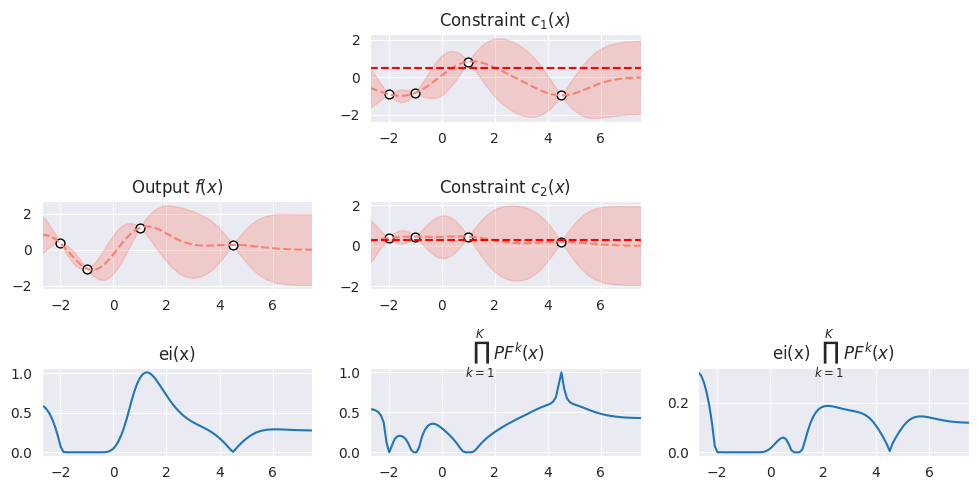

In [15]:
class plot_constrained_ei():
    def __init__(self, c1_limit, c2_limit):
        self.c1_limit = c1_limit
        self.c2_limit = c2_limit
        
    def plot(self):
        lb, ub = -2.7, 7.5
        # Create Gaussian Process Regressor
        rbf_kernel = kernel(1, sigma_f=1)
        gp_f = GaussianProcessRegressor(kernel=rbf_kernel, sigma_noise=1e-6)
        gp_c1 = GaussianProcessRegressor(kernel=rbf_kernel, sigma_noise=1e-6)
        gp_c2 = GaussianProcessRegressor(kernel=rbf_kernel, sigma_noise=1e-6)
        
        # Fit the model
        X_test = np.linspace(-2.7, 7.5, 100).reshape(-1, 1)
        X_train = np.array([-2, -1, 1, 4.5]).reshape(-1, 1)
        y, c1, c2 = constrained_evaluation(X_train)
        max_val = np.max(y[np.logical_and(c1 < self.c1_limit , c2 < self.c2_limit).reshape(-1)])
        gp_f.fit(X_train, y)
        gp_c1.fit(X_train, c1)
        gp_c2.fit(X_train, c2)
        # Make predictions
        y_pred_mean, y_pred_std = gp_f.predict(X_test)
        c1_pred_mean, c1_pred_std = gp_c1.predict(X_test)
        c2_pred_mean, c2_pred_std = gp_c2.predict(X_test)
        PF_c1 = probability_of_feasibility(gp_c1, X_test, self.c1_limit)
        PF_c2 = probability_of_feasibility(gp_c2, X_test, self.c2_limit)
        ei = expected_improvement(gp_f, max_val)
        ei_vals = -ei.evaluate(X_test)
        overall_PF = PF_c1 * PF_c2
        
        y_plot, x1_plot, c2_plot = constrained_evaluation(X_test)
        # Create a figure and a set of subplots
        sn.set_style("darkgrid")
        fig, axs = plt.subplots(3, 3, figsize=(10, 5))

        # Plot something on the left side
        axs[1, 0].plot(X_test, y_pred_mean, linestyle="--", color="salmon")
        axs[1, 0].fill_between(X_test.reshape(-1), y_pred_mean - 1.96*y_pred_std, y_pred_mean + 1.96*y_pred_std, alpha=0.3, color="salmon")
        axs[1, 0].scatter(X_train, y, color="black", facecolors='white', edgecolors='black',s=40)
        axs[1, 0].set_xlim(lb, ub)
        axs[1, 0].set_title("Output $f(x)$")
        axs[2, 0].plot(X_test, ei_vals)
        axs[2, 0].set_xlim(lb, ub)
        axs[2, 0].set_title("ei(x)")
        
        # Plot something in the center
        axs[0, 1].plot(X_test, c1_pred_mean, linestyle="--", color="salmon")
        axs[0, 1].fill_between(X_test.reshape(-1), c1_pred_mean - 1.96*c1_pred_std, c1_pred_mean + 1.96*c1_pred_std, alpha=0.3, color="salmon")
        axs[0, 1].scatter(X_train, c1, color="black", facecolors='white', edgecolors='black',s=40)
        axs[0, 1].axhline(self.c1_limit, color='r', linestyle='--')
        axs[0, 1].set_title("Constraint $c_{1}(x)$")
        axs[0, 1].set_xlim(lb, ub)
        
        axs[1, 1].plot(X_test, c2_pred_mean, linestyle="--", color="salmon")
        axs[1, 1].fill_between(X_test.reshape(-1), c2_pred_mean - 1.96*c2_pred_std, c2_pred_mean + 1.96*c2_pred_std, alpha=0.3, color="salmon")
        axs[1, 1].scatter(X_train, c2, color="black", facecolors='white', edgecolors='black',s=40)
        axs[1, 1].axhline(self.c2_limit, color='r', linestyle='--')
        axs[1, 1].set_title("Constraint $c_{2}(x)$")
        axs[1, 1].set_xlim(lb, ub)
        
        axs[2, 1].set_title("$\prod^{K}_{k=1} PF^{k}(x)$")
        axs[2, 1].plot(X_test, overall_PF)
        axs[2, 1].set_xlim(lb, ub)
        
        # Plot something on the right side
        axs[2, 2].plot(X_test, ei_vals*overall_PF)
        axs[2, 2].set_title("ei(x) $\prod^{K}_{k=1} PF^{k}(x)$")
        axs[2, 2].set_xlim(lb, ub)
        
        axs[0, 0].remove()
        axs[1, 2].remove()
        axs[0, 2].remove()
        
        plt.tight_layout()
        plt.show()
        
plot_constrained_ei(0.5, 0.3).plot()
hide_toggle()

# Bayesian Optimization with multiple objectives

$$
\max_{x \in \mathscr{X}} f_{1}(x), \dots, f_{M}(x)
$$

- Trade-off between the different objectives.
- Each function may be an expensive-to-optimize function.


In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Define the objectives function
def objectives(x):
    x1 = x[:, 0]
    x2 = x[:, 1]
    f1 = x1**2 + x2**2
    f2 = (x1 - 1)**2 + (x2 - 1)**2
    return -np.column_stack((f1, f2)) + 17.5

def domination_x1_x2(x1, x2):
    if all(x1_i >= x2_i for x1_i, x2_i in zip(x1, x2)):
        if any(x1_i > x2_i for x1_i, x2_i in zip(x1, x2)):
            return True
    return False

def dominated_by_set(x1, x_set):
    for xi in x_set:
        if domination_x1_x2(xi, x1):
            return True
    return False

class plot_multi_objective():
    def __init__(self,):
        pass
    
    def plot(self, x_new_1, x_new_2):
        X_sampled = np.array([[1.5,-0.9],
                             [-1.5,0.5],
                             [0.5, 2.5]])
        x_new = np.array([[x_new_1, x_new_2]])
        # Generate input points
        n_points_x1 = 100
        n_points_x2 = 100
        x1_range = np.linspace(-2, 3, n_points_x1)
        x2_range = np.linspace(-2, 3, n_points_x2)
        X1, X2 = np.meshgrid(x1_range, x2_range)
        input_points = np.column_stack((X1.ravel(), X2.ravel()))

        # Compute objectives
        objectives_values = objectives(input_points)
        y_sampled = objectives(X_sampled)
        f_new = objectives(x_new)

        # Plot solid input space
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].contourf(X1, X2, np.reshape(np.array([1]*n_points_x2 * n_points_x1), X1.shape), cmap='Blues')
        axs[0].scatter(x_new[:,0], x_new[:,1], color="black")
        axs[0].scatter(X_sampled[:,0], X_sampled[:,1], color="red")
            
        axs[0].set_title('Input Space')
        axs[0].set_xlabel('$X_1$')
        axs[0].set_ylabel('$X_2$')
        axs[0].set_ylim(-2.5, 3.5)
        axs[0].set_xlim(-2.5, 3.5)
        axs[0].grid(True)

        # Plot output space (objectives)
        all_points = np.concatenate([y_sampled, f_new])
        for idx, yi in enumerate(y_sampled):
            n_base_points = 3
            x_fill_between = np.linspace(-1, yi[0], n_base_points)
            color = "red" if dominated_by_set(yi, all_points) else "green"
            axs[0].scatter(X_sampled[idx,0], X_sampled[idx,1], facecolor=color, edgecolors='black', zorder =25)
            
            axs[1].fill_between(x_fill_between, 
                                np.array([-1]*n_base_points), 
                                np.array([yi[1]]*n_base_points), 
                                color="grey", 
                                alpha=0.2, 
                                zorder=20)

            axs[1].scatter(yi[0], yi[1], 
                           facecolor=color,  
                           edgecolors='black', zorder =25)
            
        axs[1].scatter(objectives_values[:, 0], objectives_values[:, 1], 
                       c='lightblue', 
                       marker='.', 
                       alpha=0.3, 
                       s=180)
        axs[0].scatter(x_new[:,0], x_new[:,1], 
                       color="red" if dominated_by_set(f_new.reshape(-1), y_sampled) else "green",
                      edgecolors='black')
        axs[1].scatter(f_new[:,0], f_new[:,1], 
                       facecolors="red" if dominated_by_set(f_new.reshape(-1), y_sampled) else "green", 
                       edgecolors='black',zorder=30)
        axs[1].set_title('Objective Space')
        axs[1].set_xlabel('Objective 1 ($f_1$)')
        axs[1].set_ylabel('Objective 2 ($f_2$)')
        axs[1].set_xlim(-1, 18)
        axs[1].set_ylim(-1, 18)
        axs[1].grid(True)
        plt.tight_layout()
        plt.show()

In [17]:
plot_multi_objective_object = plot_multi_objective()

widget = interact(plot_multi_objective_object.plot,
         x_new_1 = FloatSlider(value=-1.9, min=-2, max=3, step=0.1, description='$x_1$'),
         x_new_2 = FloatSlider(value=1.0, min=-2, max=3, step=0.1, description='$x_2$'))


hide_toggle()

interactive(children=(FloatSlider(value=-1.9, description='$x_1$', max=3.0, min=-2.0), FloatSlider(value=1.0, …

# Bayesian Optimization with multiple objectives:

- **Hypervolume based**:
    - Computes the volume of the area enclosed by the Pareto front approximation and a reference point.
    
- **Scalarization based**:
    - Objectives may be aggreaged by an scalarization function, e.g., 
    
      $$
    U(x) = \sum_{j=1,\dots,M} \theta_{j}f_{j}(x) \quad, s.t. \sum_{j=1,\dots,M} \theta_{j} = 1
    $$   

In [18]:
import matplotlib.pyplot as plt

# Define the coordinates of the points

set_points = np.array([[14.44, 13.64],
                         [15. ,  11.  ],
                         [11. ,  15.  ]])

def plot_region_given_points(points, color_region, alpha, zorder):
    base_points = []
    # Plot the horizontal and vertical segments
    for i in range(len(points) - 1):
        x1, y1 = points[i]
        x2, y2 = points[i + 1]
        if x1 != x2:
            base_points.append([x1, y1])
            base_points.append([x2, y1])
        if y1 != y2:
            base_points.append([x2, y1])
            base_points.append([x2, y2])

    # Connect the last point to the first point
    x1, y1 = points[-1]
    x2, y2 = points[0]
    if x1 != x2:
        base_points.append([x1, y1])
        base_points.append([x2, y1])
    if y1 != y2:
        base_points.append([x2, y1])
        base_points.append([x2, y2])

    # Fill the region inside the rectangles with color
    plt.fill(np.array(base_points)[:,0], np.array(base_points)[:,1], color=color_region, alpha=alpha, zorder=zorder)
    
def plot_region(point, reference_point, set_points):
    
    points = np.concatenate([reference_point, set_points])
    sorted_indices = np.argsort(points[:, 1])
    points = points[sorted_indices]
    overall_region = np.concatenate([point, reference_point])
    # Extract x and y coordinates of the points
    x_coords, y_coords = zip(*points)

    # Plot the points
    for idx, yi in enumerate(set_points):
            plt.scatter(yi[0], yi[1], 
                       facecolor="red" if dominated_by_set(yi, point) else "green",  
                       edgecolors='black', zorder =25, s=50)
    
    plt.scatter(point[:,0], point[:,1], 
               facecolors="red" if dominated_by_set(point.reshape(-1), set_points) else "green", 
               edgecolors='black', marker="*",zorder=30, s=200)
    plt.scatter(reference_point[:,0], reference_point[:,1], color="black", marker="x", zorder=30)
    plot_region_given_points(overall_region, color_region="green", alpha=1, zorder=10)
    plot_region_given_points(points, color_region="green", alpha=1, zorder=10)
    

    # Set labels and title
    plt.xlabel('Objective $f_{1}$')
    plt.ylabel('Objective $f_{2}$')
    plt.title('Objective Space')
    plt.xlim(10, 20)
    plt.ylim(10, 20)
    plt.grid(True)

def plot_utility(point, weight, set_points):
    theta_1 = weight
    theta_2 = 1- weight
    all_designs = np.concatenate([point, set_points])
    x = np.linspace(10, 20, 100)
    utility = np.sum(all_designs*np.array([theta_1, theta_2]), axis=1)
    max_utility_location = all_designs[np.argmax(utility)]
    y = -x*(theta_1/theta_2) + (max_utility_location[0] * theta_1 + max_utility_location[1]*theta_2)/theta_2
    
    plt.plot(x, y, color="black", linestyle="--")
     # Plot the points
    for idx, yi in enumerate(set_points):
            plt.scatter(yi[0], yi[1], 
                       facecolor="red" if dominated_by_set(yi, point) else "green",  
                       edgecolors='black', zorder =25, s=50)
    
    plt.scatter(point[:,0], point[:,1], 
               facecolors="red" if dominated_by_set(point.reshape(-1), set_points) else "green", 
               edgecolors='black', marker="*",zorder=30, s=200)
    # Set labels and title
    plt.xlabel('Objective $f_{1}$')
    plt.ylabel('Objective $f_{2}$')
    plt.title('Objective Space')
    plt.xlim(10, 20)
    plt.ylim(10, 20)
    plt.grid(True)

class plot_metrics_multi_objective():
    def __init__(self, init_point, reference_point, weight, set_points, method):
        self.reference_point = reference_point
        self.weight = weight
        self.set_points = set_points
        self.plotting_method = method
        self.x1 = init_point.reshape(-1)[0]
        self.x2 = init_point.reshape(-1)[1]
        
    def update_method(self,method):
        self.plotting_method = method
        
    def plot_hypervolume(self):
        self.init_point = np.array([[self.x1, self.x2]])
        plot_region(self.init_point, self.reference_point, self.set_points)
        plt.show()
        
    def plot_utility(self):
        self.init_point = np.array([[self.x1, self.x2]])
        plot_utility(self.init_point, self.weight, self.set_points)
        plt.show()
        
    def update_location_x1(self, x1):
        self.x1 = x1
        if self.plotting_method == "hypervolume":
            self.plot_hypervolume()
        else:
            self.plot_utility()
            
    def update_location_x2(self, x2):
        self.x2 = x2
        if self.plotting_method == "hypervolume":
            self.plot_hypervolume()
        else:
            self.plot_utility()

In [19]:
plot_metrics = plot_metrics_multi_objective(init_point = np.array([[13.5, 15.0]]),
                                            reference_point=np.array([[10.5, 10.5]]),
                                           weight = 0.5,
                                           set_points = set_points, 
                                            method="utility")
output6 = widgets.Output()

def metric_changed(graph_type):
    with output6:
        output6.clear_output(wait=True)
        plot_metrics.update_method(graph_type)
        if graph_type == "hypervolume":
            plot_metrics.plot_hypervolume()
        else:
            plot_metrics.plot_utility()
        plt.show()

def metric_location_changed_x1(x_1):
    with output6:
        output6.clear_output(wait=True)
        plot_metrics.update_location_x1(x_1["new"])
        plt.show()
        
def metric_location_changed_x2(x_2):
    with output6:
        output6.clear_output(wait=True)
        plot_metrics.update_location_x2(x_2["new"])
        plt.show()
        
options = ["hypervolume", "scalarization"]
metric_widget = widgets.Dropdown(options=options, description=r'metric', value=options[0], layout=Layout(width='60%'))
metric_widget.observe(lambda event: metric_changed(event['new']), names='value')


x1_slider = FloatSlider(value=13.5, min=10.5, max=18, step=0.1, description='$x_1$')
x2_slider = FloatSlider(value=15.0, min=10.5, max=18, step=0.1, description='$x_2$')
x1_slider.observe(metric_location_changed_x1, names='value')
x2_slider.observe(metric_location_changed_x2, names='value')

display(widgets.VBox([metric_widget, x1_slider,x2_slider, output6]))
hide_toggle()

## Bayesian Optimization with multiple objectives

- Hypervolume Based BO algorithms
    - SExI-EGO [Emmerich et al. (2011)].
    - EMO [Couckuyt et al. (2014)].
    - BMOO [Feliot et al. (2017)].


- Scalarization Based BO algorithms
    - ParEGO [Knowles (2006)].
    - EI-UU [Astudillo et al. (2020)].
    - MOEA/D-EGO [Zhang et al. (2010)].
    
see Rojas-Gonzalez, et al "A survey on kriging-based infill algorithms for multiobjective simulation optimization"

# Other exotic settings.

- Optimize problems with a high number of input/output dimensions.
- Optimizing over non-euclidian spaces.
- Including user preferences for multi-objective problems.
- Acquisition functions with multiple steps.
- Bayesian optimization with heteroskedastic noise.

# Benefits

* Global Optimization of black-box and (potentially) functions

* Sample Efficient 


# Difficulties

* Limited to Smooth Functions

* Struggles to scale to high number of dimensions or observations.

# RISE configuration

In [20]:
from traitlets.config.manager import BaseJSONConfigManager
from pathlib import Path
path = Path.home() / ".jupyter" / "nbconfig"
cm = BaseJSONConfigManager(config_dir=str(path))
tmp = cm.update(
        "rise",
        {
            "theme": "simple",
            "transition": "fade",
            "start_slideshow_at": "selected",
            "autolaunch": True,
            "width": "100%",
            "height": "100%",
            "header": "",
            "footer":"",
            "scroll": True,
            "enable_chalkboard": True,
            "slideNumber": True,
            "center": False,
            "controlsLayout": "edges",
            "slideNumber": True,
            "hash": True,
        }
    )